In [40]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the action transformation function
def transform_action_values(n_actions, min_action=-2.0, max_action=2.0):
    linear_actions = np.linspace(-1, 1, n_actions)
    non_linear_actions = np.sign(linear_actions) * (linear_actions ** 2)
    scaled_actions = min_action + (non_linear_actions + 1) * (max_action - min_action) / 2
    return scaled_actions

# Define the Replay Buffer class
class ReplayBuffer:
    def __init__(self, buffer_limit):
        self.buffer = deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        states, actions, rewards, next_states, dones = zip(*mini_batch)

        # Convert lists of arrays/tensors to tensors
        states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in states])
        actions = torch.tensor(actions, dtype=torch.float32).unsqueeze(1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
        next_states = torch.stack([torch.tensor(s, dtype=torch.float32) for s in next_states])
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

        return states.to(device), actions.to(device), rewards.to(device), next_states.to(device), dones.to(device)


    def size(self):
        return len(self.buffer)

# Define the Q-Network class
class DQNNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, action_size)

    def forward(self, state):
        x = F.leaky_relu(self.fc1(state))
        x = F.leaky_relu(self.fc2(x))
        return self.fc3(x)

# Define the Agent class
class Agent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = ReplayBuffer(1000000)
        self.batch_size = batch_size
        self.gamma = 0.995
        self.epsilon = 0.9
        self.epsilon_decay = 0.9
        self.epsilon_min = 0.001
        self.model = DQNNetwork(state_size, action_size).to(device)
        self.target_model = DQNNetwork(state_size, action_size).to(device)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.01)
        self.action_values = transform_action_values(action_size)

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def select_action(self, state_tensor):
        if np.random.rand() > self.epsilon:
            action_index = torch.argmax(self.model(state_tensor)).item()
            action = self.action_values[action_index]
        else:
            action_index = np.random.randint(len(self.action_values))
            action = self.action_values[action_index]
        return action, action_index

    def store_experience(self, state, action, reward, next_state, done):
        self.memory.put((state, action, reward, next_state, done))

    def train_agent(self):
        if self.memory.size() < self.batch_size:
            return

        s_batch, a_batch, r_batch, s_prime_batch, done_batch = self.memory.sample(self.batch_size)

        # Move batches to the correct device
        s_batch = s_batch.to(device)
        a_batch = a_batch.to(device).type(torch.int64)
        r_batch = r_batch.to(device)
        s_prime_batch = s_prime_batch.to(device)
        done_batch = done_batch.to(device)

        # Calculate Q values and expected Q values
        q_values = self.model(s_batch).gather(1, a_batch)
        next_q_values = self.target_model(s_prime_batch).detach().max(1)[0].unsqueeze(1)
        expected_q_values = r_batch + self.gamma * next_q_values * (1 - done_batch)

        # Compute loss
        loss = F.smooth_l1_loss(q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Epsilon decay
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        # Soft update the target network
        for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - 0.01) + param.data * 0.01)

# Main training loop
if __name__ == "__main__":
    env = gym.make('Pendulum-v1', render_mode='human')
    state_size = env.observation_space.shape[0]
    action_size = 11  # Number of discrete actions

    agent = Agent(state_size, action_size, batch_size=256)

    num_episodes = 100
    score_list = []

    for episode in range(num_episodes):
        state, info = env.reset()
        score = 0
        done = False

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            action, action_index = agent.select_action(state_tensor)
            next_state, reward, done, truncated, _ = env.step([action])

            # Directly store the numpy arrays
            agent.store_experience(state, action_index, reward, next_state, done)

            # Train the agent
            agent.train_agent()

            # Update the state and accumulate the score
            state = next_state
            score += reward

        # Append the score of the episode to the list for plotting
        score_list.append(score)
        print(f"Episode {episode + 1}/{num_episodes}, Score: {score}")

    # Plotting the scores
    plt.plot(score_list)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Training Progress')
    plt.show()

    # Save the model
    torch.save(agent.model.state_dict(), 'pendulum_dqn_model.pth')


KeyboardInterrupt: 

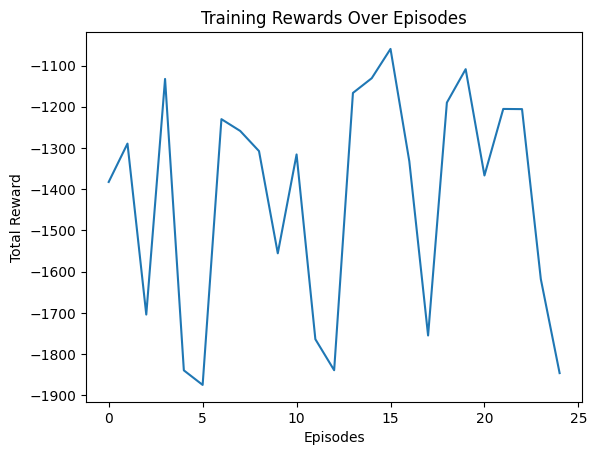

In [ ]:
# Plotting the scores
plt.plot(scores)
plt.title('Training Rewards Over Episodes')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.show()

In [ ]:
env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
state_size = env.observation_space.shape[0]
action_size = 6  # Discretize action space into 30 actions

agent = Agent(state_size, action_size, batch_size=128)

run_test_episodes(env, agent, num_episodes=10)

ValueError: expected sequence of length 3 at dim 1 (got 0)